# Cornell corpus

In this notebook includes:

- Loading and cleaning the datasets in the Cornell corpus. 
- Completing gender information using the TMDB dataset and manual annotations
- Implementing preprocessing methods from Schofield, A., & Mehr, L. (2016). Gender-Distinguishing Features in Film Dialogue. Proceedings of the Fifth Workshop on Computational Linguistics for Literature, 32–39. https://doi.org/10.18653/v1/W16-0204

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, LeaveOneGroupOut,GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import sklearn
import pickle
import re
import string
import myfunctions
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

c:\Users\Dell\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Go to main directory
%cd ..

c:\Users\Dell\Documents\UCA DSAI\Internship 2\Code\text-models


# Data cleanning

In [10]:
# Functions for data cleaning and loading the files in pandas data frame format

def clean_cornell(directory, file_name, return_lines = False):
    '''It does data cleaning of the cornell dataset based mostly on special characters. Some processes are very specific to typos in the Cornell dataset
    Inputs: 
        directory: the directory where the txt file is
        file_name: the name of the txt file (without the .txt)
        return_lines: boolean to return or not the lines
    '''

    with open(directory + file_name + '.txt','r',encoding='iso-8859-1') as f:
        lines = f.readlines()

    # Optional replacements     
    # Replace Š by s
    lines = [str(re.sub("\x8a", "s", l)) for l in lines]
    # Replace á, à and others by a
    lines = [str(re.sub("[\xe0|\xe1|\xe2|\xe3|\xe4|\xe5]", "a", l)) for l in lines]
    # Replace Á, À and others by A
    lines = [str(re.sub("[\xc0|\xc1|\xc2|\xc3|\xc4|\xc5]", "A", l)) for l in lines]
    # Replace è, é and others by e
    lines = [str(re.sub("[\xe8|\xe9|\xea|\xeb]", "e", l)) for l in lines]
    # Replace È, É and others by E
    lines = [str(re.sub("[\xc8|\xc9|\xca|\xcb]", "E", l)) for l in lines]
    # Replace í, ì and others by i
    lines = [str(re.sub("[\xec|\xed|\xee|\xef]", "i", l)) for l in lines]
    # Replace Í, Ì and others by I
    lines = [str(re.sub("[\xcc|\xcd|\xce|\xcf]", "I", l)) for l in lines]
    # Replace ó, ò and others by o
    lines = [str(re.sub("[\xf2|\xf3|\xf4|\xf5|\xf6]", "o", l)) for l in lines]
    # Replace Ó, Ò and others by O
    lines = [str(re.sub("[\xd2|\xd3|\xd4|\xd5|\xd6]", "O", l)) for l in lines]
    # Replace ú, ù and others by u
    lines = [str(re.sub("[\xf9|\xfa|\xfb|\xfc]", "u", l)) for l in lines]
    # Replace Ú, Ù and others by U
    lines = [str(re.sub("[\xd9|\xda|\xdb|\xdc]", "U", l)) for l in lines]
    # Replace £ by nothing
    lines = [str(re.sub("\xa3", "", l)) for l in lines]
    # Replace ñ by n
    lines = [str(re.sub("\xf1", "n", l)) for l in lines]
    # Replace Ñ by N
    lines = [str(re.sub("\xd1", "N", l)) for l in lines]
    # Replace Ç by C
    lines = [str(re.sub("\xc7", "C", l)) for l in lines]
    # Replace ç by c
    lines = [str(re.sub("\xe7", "c", l)) for l in lines]

    # Necessary replacements
    # Replace “, ”, ’, ‘, «, », ¹ (this case is specific to Cornell) by '
    lines = [str(re.sub("[\x93|\x94|\x92|\x91|\xab|\xbb|\xb9]", "'", l)) for l in lines]
    # Replace ——, –, soft hyphen by -
    lines = [str(re.sub("[\x97|\x96|\xAD]", "-", l)) for l in lines]
    # # Replace – by -
    # lines = [str(re.sub("\x96", "-", l)) for l in lines]
    # # Replace ­­­soft hyphen by -
    # lines = [str(re.sub("\xAD", "-", l)) for l in lines]
    # Replace … by ...
    lines = [str(re.sub("\x85", "...", l)) for l in lines]
    # Replace ‚ by ,
    lines = [str(re.sub("\x82", ",", l)) for l in lines]
    # Replace the weird occurrences of Œ (this is very specific to the Cornell dataset)
    lines = [str(re.sub("\x8cem", "them", l)) for l in lines]
    lines = [str(re.sub("\x8chood", "hood", l)) for l in lines]
    lines = [str(re.sub("\x8ctill", "still", l)) for l in lines]
    lines = [str(re.sub("\x8cscuse", "Excuse", l)) for l in lines]
    lines = [str(re.sub("\x8cCause", "Because", l)) for l in lines]
    # Replace the weird occurrences of ¥ (this is very specific to the Cornell dataset)
    lines = [str(re.sub("\xa5our", "Your", l)) for l in lines]
    # Replace the weird occurrences of ß (this is very specific to the Cornell dataset)
    lines = [str(re.sub("\xdfoor", "floor", l)) for l in lines]
    # Replace - - by a space
    lines = [str(re.sub("- -", " ", l)) for l in lines]
    # Replace · ² ³ by a space
    lines = [str(re.sub("[\xb7|\xb2|\xb3]", " ", l)) for l in lines]
    # Replace more than 2 dashes with a space
    lines = [str(re.sub("[-]{2,}", " ", l)) for l in lines]
    # Replace more than 2 points with a space
    lines = [str(re.sub("[.]{3,}", " ", l)) for l in lines]
    # Remove spaces around ' , ex: can ' t becomes can't 
    lines = [str(re.sub(" ' ", "'", l)) for l in lines] 
    # Replace 2 or more spaces for 1 space
    lines = [str(re.sub("[ \t]{2,}", " ", l)) for l in lines]
    # Remove spaces before change of line
    lines = [str(re.sub(" \n", "\n", l)) for l in lines]
    # Replace patterns like . . . . . and similar by ...
    lines = [str(re.sub("\s*(\.\s)+\.", "...", l)) for l in lines]


    # Save the cleanned text in a text file
    
    text = ''.join(lines)
    #open text file
    text_file = open(directory+file_name+'_clean.txt', "w")
    #write string to file
    text_file.write(text)
    #close file
    text_file.close()

    if return_lines:
        return lines



def from_cornell_corpus_to_pandas(directory, file, column_names, use_latin_1=False):
    '''
    Given a directory, a file in the cornell dataset format and column names, it creates a pandas dataframe.
    '''
    if use_latin_1:
        return pd.read_csv(directory+file, sep=' \+\+\+\$\+\+\+ ', engine = "python", index_col = False, names = column_names, encoding='latin-1')
    else: 
         return pd.read_csv(directory+file, sep=' \+\+\+\$\+\+\+ ', engine = "python", index_col = False, names = column_names) 

In [11]:
# Clean some non readable characters and others the files of the cornell dataset
directory = "datasets/cornell_corpus/"    
clean_cornell(directory, 'movie_lines')
clean_cornell(directory, 'movie_titles_metadata')
clean_cornell(directory, 'movie_characters_metadata')

In [12]:
# loading datasets 
movie_lines = from_cornell_corpus_to_pandas(directory, 'movie_lines_clean.txt', column_names = ['lineID', 'characterID','movieID','character_name', 'text'])    
movie_titles_metadata = from_cornell_corpus_to_pandas(directory, 'movie_titles_metadata_clean.txt', column_names = ['movieID', 'movie_title', 'movie_year','IMDB_rating', 'IMDB_votes', 'genres'])
movie_characters_metadata = from_cornell_corpus_to_pandas(directory, 'movie_characters_metadata_clean.txt', column_names = ['characterID','character_name','movieID','movie_title','gender','position_in_credits'])
movie_conversations = from_cornell_corpus_to_pandas(directory, 'movie_conversations.txt', column_names = ['characterID1','characterID2','movieID','lineIDs'])

In [6]:
movie_lines

,lineID,characterID,movieID,character_name,text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.
...,...,...,...,...,...
304708,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...
304709,L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...
304710,L666369,u9030,m616,DURNFORD,"Your orders, Mr Vereker?"
304711,L666257,u9030,m616,DURNFORD,"Good ones, yes, Mr Vereker. Gentlemen who can ..."


In [7]:
movie_titles_metadata

,movieID,movie_title,movie_year,IMDB_rating,IMDB_votes,genres
0,m0,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.2,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.1,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.4,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.9,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."
...,...,...,...,...,...,...
612,m612,watchmen,2009,7.8,135229,"['action', 'crime', 'fantasy', 'mystery', 'sci..."
613,m613,xxx,2002,5.6,53505,"['action', 'adventure', 'crime']"
614,m614,x-men,2000,7.4,122149,"['action', 'sci-fi']"
615,m615,young frankenstein,1974,8.0,57618,"['comedy', 'sci-fi']"


In [8]:
movie_characters_metadata

,characterID,character_name,movieID,movie_title,gender,position_in_credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6
...,...,...,...,...,...,...
9030,u9030,DURNFORD,m616,zulu dawn,?,?
9031,u9031,MELVILL,m616,zulu dawn,?,?
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,?,?
9033,u9033,STUART SMITH,m616,zulu dawn,?,?


In [9]:
movie_conversations

,characterID1,characterID2,movieID,lineIDs
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"
...,...,...,...,...
83092,u9028,u9031,m616,"['L666324', 'L666325', 'L666326', 'L666327']"
83093,u9028,u9031,m616,"['L666575', 'L666576']"
83094,u9030,u9034,m616,"['L666256', 'L666257']"
83095,u9030,u9034,m616,"['L666369', 'L666370', 'L666371', 'L666372']"


# Gender extra information

We use the TMDB dataset (available in kaggle) and manual annotations to complete gender information in the Cornell Corpus.

**1. Get characters that don't have gender information in the Cornell corpus**

In [10]:
# Get the cases without gender 
movie_characters_metadata_no_gender = movie_characters_metadata.loc[movie_characters_metadata['gender'] == '?']
movie_characters_metadata_no_gender

,characterID,character_name,movieID,movie_title,gender,position_in_credits
1,u1,BRUCE,m0,10 things i hate about you,?,?
3,u3,CHASTITY,m0,10 things i hate about you,?,?
8,u8,MISS PERKY,m0,10 things i hate about you,?,?
10,u10,SHARON,m0,10 things i hate about you,?,?
12,u12,ALONSO,m1,1492: conquest of paradise,?,?
...,...,...,...,...,...,...
9030,u9030,DURNFORD,m616,zulu dawn,?,?
9031,u9031,MELVILL,m616,zulu dawn,?,?
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,?,?
9033,u9033,STUART SMITH,m616,zulu dawn,?,?


**2 Adding TMDB dataset information**

Each row of the TMDB dataset contains information about a movie. The column ```cast``` contain json files with information about characters, including the gender.  

In [11]:
# Loading the credits information from TMDB
tmdb_credits = pd.read_csv('datasets/tmdb/tmdb_5000_credits.csv')
tmdb_credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [12]:
# Create empty pandas dataframe
tmdb_characters = pd.DataFrame(columns=pd.read_json(tmdb_credits['cast'][0]).columns)

# For each movie, get the cast information
for i in tqdm(range(len(tmdb_credits))): 
    df = pd.read_json(tmdb_credits['cast'][i])
    df['title'] = tmdb_credits['title'][i]
    tmdb_characters = pd.concat([tmdb_characters, df])

100%|██████████| 4803/4803 [02:16<00:00, 35.08it/s]


In [13]:
# Remove characters without gender information
tmdb_characters_with_gender = tmdb_characters[tmdb_characters['gender'] != 0]

In [14]:
# Some variable transformations in the tmdb_characters_with_gender dataset

# Change the coding of Male and Female to match Cornell's
tmdb_characters_with_gender['gender'] = np.where(tmdb_characters_with_gender['gender'] == 2, 'M', 'F')
# Put in upper of lower case to make the variables match with Cornell's format
tmdb_characters_with_gender['character'] = tmdb_characters_with_gender['character'].str.upper()
tmdb_characters_with_gender['title'] = tmdb_characters_with_gender['title'].str.lower()

tmdb_characters_with_gender

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,cast_id,character,credit_id,gender,id,name,order,title
0,242,JAKE SULLY,5602a8a7c3a3685532001c9a,M,65731,Sam Worthington,0,avatar
1,3,NEYTIRI,52fe48009251416c750ac9cb,F,8691,Zoe Saldana,1,avatar
2,25,DR. GRACE AUGUSTINE,52fe48009251416c750aca39,F,10205,Sigourney Weaver,2,avatar
3,4,COL. QUARITCH,52fe48009251416c750ac9cf,M,32747,Stephen Lang,3,avatar
4,5,TRUDY CHACON,52fe48009251416c750ac9d3,F,17647,Michelle Rodriguez,4,avatar
...,...,...,...,...,...,...,...,...
2,6,HIMSELF,58ce01339251415a410167f0,M,3034,Corey Feldman,2,my date with drew
3,8,HIMSELF,58ce018c9251415a7d016e36,M,21315,Eric Roberts,3,my date with drew
5,10,HIMSELF,58ce01d19251415a8b0168be,M,2231,Samuel L. Jackson,5,my date with drew
6,11,HIMSELF,58ce01dd9251415a39016580,M,14407,Matt LeBlanc,6,my date with drew


Now we complete part of the the gender information for Cornell using the information in TMDB.
Note that, ```inner_tmdb_cornell``` is the dataframe that contains all the characters that did not have gender in the Cornell Dataset, but whose gender was obtained from TMDB.


In [15]:
# Inner join of TMDB information with the Cornell genderless characters
inner_tmdb_cornell = pd.merge(movie_characters_metadata_no_gender,tmdb_characters_with_gender,how='inner',left_on=['character_name','movie_title'],right_on=['character','title'])
# Keep only Cornell's information with the new information about gender 
inner_tmdb_cornell = inner_tmdb_cornell.rename(columns={"gender_y": "gender"})
inner_tmdb_cornell = inner_tmdb_cornell[list(movie_characters_metadata.columns)]
# Remove duplicates
inner_tmdb_cornell = inner_tmdb_cornell.drop_duplicates()

inner_tmdb_cornell

,characterID,character_name,movieID,movie_title,gender,position_in_credits
0,u3,CHASTITY,m0,10 things i hate about you,F,?
1,u37,MAGGIE,m2,15 minutes,F,?
2,u43,ROBERT HAWKINS,m2,15 minutes,M,?
3,u46,STEPHEN GELLER,m2,15 minutes,M,?
4,u54,ELENA,m3,2001: a space odyssey,F,?
...,...,...,...,...,...,...
586,u8940,ELAINE,m609,witness,F,?
587,u8962,UNCLE HENRY,m610,the wizard of oz,M,?
588,u8969,LACHAISE,m611,the world is not enough,M,?
589,u8971,RENARD,m611,the world is not enough,M,?


**3. Adding manual annotations information**

In [16]:
# Get characters without gender in the cornell dataset and TMDB dataset
cornell_tmdb_no_gender = pd.merge(movie_characters_metadata_no_gender, tmdb_characters_with_gender, left_on=['character_name','movie_title'],right_on=['character','title'], how="outer", indicator=True).query('_merge=="left_only"')
cornell_tmdb_no_gender = cornell_tmdb_no_gender.rename(columns={"gender_x": "gender"})
cornell_tmdb_no_gender = cornell_tmdb_no_gender[list(movie_characters_metadata.columns)]

# # This step was necesarry only once, to create the csv for manual annotations
# # Save this to csv to be completed  
# cornell_tmdb_no_gender.to_csv(directory + 'cornell_tmdb_no_gender.csv')

In [17]:
# Load the file with extra gender information (this is the file with manual annotations)
cornell_tmdb_extra_gender_info = pd.read_csv(directory+'cornell_tmdb_extra_gender_info.csv')

**4. Merge all sources**

Cornell, TMDB and manual annotations

In [18]:
# Merge of sources
# fill NAN with empty string
movie_characters_metadata_gender_info = pd \
.merge(movie_characters_metadata, inner_tmdb_cornell, how = "outer", on = ["characterID", "character_name", "movieID", "movie_title","position_in_credits"],suffixes=('_cornell', '_tmdb')) \
.merge(cornell_tmdb_extra_gender_info, how = "outer", on = ["characterID", "character_name", "movieID", "movie_title","position_in_credits"]) \
.fillna('')

# Merge genders of all sources
movie_characters_metadata_gender_info['gender'] = movie_characters_metadata_gender_info['gender_cornell'] + movie_characters_metadata_gender_info['gender_tmdb'] + movie_characters_metadata_gender_info['gender']
movie_characters_metadata_gender_info['gender'] = movie_characters_metadata_gender_info['gender'].replace("\?", "", regex=True)

# Keep only one column of gender
movie_characters_metadata_gender_info = movie_characters_metadata_gender_info.drop(columns=["gender_cornell", "position_in_credits", "gender_tmdb"])
movie_characters_metadata_gender_info

,characterID,character_name,movieID,movie_title,gender
0,u0,BIANCA,m0,10 things i hate about you,f
1,u1,BRUCE,m0,10 things i hate about you,M
2,u2,CAMERON,m0,10 things i hate about you,m
3,u3,CHASTITY,m0,10 things i hate about you,F
4,u4,JOEY,m0,10 things i hate about you,m
...,...,...,...,...,...
9030,u9030,DURNFORD,m616,zulu dawn,M
9031,u9031,MELVILL,m616,zulu dawn,M
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,M
9033,u9033,STUART SMITH,m616,zulu dawn,M


In [19]:
# Join datasets, delete variables that we don't need, remove dialogues without text
cornell = movie_lines[np.array(movie_lines['text']) != None] 
cornell = cornell \
.merge(movie_characters_metadata_gender_info, on = ['characterID','character_name','movieID'], how = 'left') \
.merge(movie_titles_metadata, on = ['movieID'], how = 'left') \
.drop(columns=['lineID', 'movie_title_x', 'IMDB_rating', 'IMDB_votes']) \
.rename(columns={'movie_title_y': "movie_title"})

# Filter for only the dialogues with gender information
cornell = cornell.loc[cornell['gender'] != '?']
cornell = cornell.loc[cornell['gender'] != '']
# Gender always in caps
cornell['gender'] = cornell['gender'].str.upper()
# Transform genre strings into lists
cornell['genres'] = cornell['genres'].str.replace("[\[\]']","",regex=True)
cornell['genres'] = cornell['genres'].str.replace(" ","")
cornell = cornell.assign(genres=cornell.genres.str.split(","))

cornell


,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres
0,u0,m0,BIANCA,They do not!,F,10 things i hate about you,1999,"[comedy, romance]"
1,u2,m0,CAMERON,They do to!,M,10 things i hate about you,1999,"[comedy, romance]"
2,u0,m0,BIANCA,I hope so.,F,10 things i hate about you,1999,"[comedy, romance]"
3,u2,m0,CAMERON,She okay?,M,10 things i hate about you,1999,"[comedy, romance]"
4,u0,m0,BIANCA,Let's go.,F,10 things i hate about you,1999,"[comedy, romance]"
...,...,...,...,...,...,...,...,...
304365,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,M,zulu dawn,1979,"[action, adventure, drama, history, war]"
304366,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...,M,zulu dawn,1979,"[action, adventure, drama, history, war]"
304367,u9030,m616,DURNFORD,"Your orders, Mr Vereker?",M,zulu dawn,1979,"[action, adventure, drama, history, war]"
304368,u9030,m616,DURNFORD,"Good ones, yes, Mr Vereker. Gentlemen who can ...",M,zulu dawn,1979,"[action, adventure, drama, history, war]"


In [20]:
# Info

print('About gender annotations: \n ')
print('Total number of characters:', len(movie_characters_metadata))

print('# characters with gender info in Cornell:', len(movie_characters_metadata[movie_characters_metadata['gender'] != '?']))
print('# characters annotated automatically', len(inner_tmdb_cornell) )
print('# characters annotated manually', len(cornell_tmdb_extra_gender_info[cornell_tmdb_extra_gender_info['gender'] != '?']))
print('Number of characters with gender information:', len(movie_characters_metadata_gender_info[movie_characters_metadata_gender_info['gender'] != ""]))
print('% of dialogues with gender info', len(cornell) / len(movie_lines))
print('Dialogues with gender info', len(cornell))

print('\nOther info \n ')
print('Total number of words', sum([len(i.split(' ')) for i in np.array(cornell['text'])]))
print('# of movies', len(np.unique(cornell['movieID'])))
print('Years: ', np.min(cornell['movie_year']), '-', np.max(cornell['movie_year']))
print('Dialogues by gender:')
cornell['gender'].value_counts() / len(cornell)

About gender annotations: 
 
Total number of characters: 9035
# characters with gender info in Cornell: 3015
# characters annotated automatically 588
# characters annotated manually 3806
Number of characters with gender information: 7409
% of dialogues with gender info 0.9402322841493471
Dialogues with gender info 286501

Other info 
 
Total number of words 3001374
# of movies 615
Years:  1927 - 2010
Dialogues by gender:


M    0.706221
F    0.293779
Name: gender, dtype: float64

# To/from pickle

In [21]:
# Save Cornell to pickle
cornell.to_pickle("datasets/cornell_corpus/cornell.pkl")  
cornell.to_csv("datasets/cornell_corpus/cornell.csv") 

In [22]:
# Read from pickle
cornell = pd.read_pickle("datasets/cornell_corpus/cornell.pkl")  
cornell

,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres
0,u0,m0,BIANCA,They do not!,F,10 things i hate about you,1999,"[comedy, romance]"
1,u2,m0,CAMERON,They do to!,M,10 things i hate about you,1999,"[comedy, romance]"
2,u0,m0,BIANCA,I hope so.,F,10 things i hate about you,1999,"[comedy, romance]"
3,u2,m0,CAMERON,She okay?,M,10 things i hate about you,1999,"[comedy, romance]"
4,u0,m0,BIANCA,Let's go.,F,10 things i hate about you,1999,"[comedy, romance]"
...,...,...,...,...,...,...,...,...
304365,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,M,zulu dawn,1979,"[action, adventure, drama, history, war]"
304366,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...,M,zulu dawn,1979,"[action, adventure, drama, history, war]"
304367,u9030,m616,DURNFORD,"Your orders, Mr Vereker?",M,zulu dawn,1979,"[action, adventure, drama, history, war]"
304368,u9030,m616,DURNFORD,"Good ones, yes, Mr Vereker. Gentlemen who can ...",M,zulu dawn,1979,"[action, adventure, drama, history, war]"


# Preprocessing 

According to Schofield, A., & Mehr, L. (2016). Gender-Distinguishing Features in Film Dialogue. Proceedings of the Fifth Workshop on Computational Linguistics for Literature, 32–39. https://doi.org/10.18653/v1/W16-0204

**1. Remove puntuation**

In [24]:
cornell['text_with_punctuation'] = cornell['text']
cornell['text'] = cornell['text'].str.replace('[{}]'.format(string.punctuation), '', regex=True)
# Delete dialogues that become NA when removing punctuation
cornell = cornell.loc[cornell['text']!='']
cornell

,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres,text_with_punctuation
0,u0,m0,BIANCA,They do not,F,10 things i hate about you,1999,"[comedy, romance]",They do not!
1,u2,m0,CAMERON,They do to,M,10 things i hate about you,1999,"[comedy, romance]",They do to!
2,u0,m0,BIANCA,I hope so,F,10 things i hate about you,1999,"[comedy, romance]",I hope so.
3,u2,m0,CAMERON,She okay,M,10 things i hate about you,1999,"[comedy, romance]",She okay?
4,u0,m0,BIANCA,Lets go,F,10 things i hate about you,1999,"[comedy, romance]",Let's go.
...,...,...,...,...,...,...,...,...,...
304365,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,M,zulu dawn,1979,"[action, adventure, drama, history, war]",Lord Chelmsford seems to want me to stay back ...
304366,u9034,m616,VEREKER,Im to take the Sikali with the main column to ...,M,zulu dawn,1979,"[action, adventure, drama, history, war]",I'm to take the Sikali with the main column to...
304367,u9030,m616,DURNFORD,Your orders Mr Vereker,M,zulu dawn,1979,"[action, adventure, drama, history, war]","Your orders, Mr Vereker?"
304368,u9030,m616,DURNFORD,Good ones yes Mr Vereker Gentlemen who can rid...,M,zulu dawn,1979,"[action, adventure, drama, history, war]","Good ones, yes, Mr Vereker. Gentlemen who can ..."


Each of the dialogues, we break it into sentences and delete those sentences that don't contain a single letter or number. This important because ProtoryNet works at sentence level.

In [25]:
# Delete sentences that only contain punctuation
cornell['text_with_punctuation'] = cornell['text_with_punctuation'].apply(lambda x: ' '.join([i for i in nltk.tokenize.sent_tokenize(x) if not bool(re.search('^[^a-zA-Z0-9]*$', i ))]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**2. Keep only characters with at least 3 conversations, 10 utterances and 100 or more words spoken in total**

In [26]:
# Number of conversations by character. 
# The characterID appears once for each conversation they were involved into
character_in_coversation = np.concatenate((movie_conversations['characterID1'],movie_conversations['characterID2']))
# Count the number of conversations by character
character_number_of_conversations = pd.Series(character_in_coversation).value_counts().rename_axis('characterID').reset_index(name='number_conversations')
# Keep characters with at 3 or more conversations
character_3_or_more_conversations = character_number_of_conversations[character_number_of_conversations['number_conversations']>=3]
character_3_or_more_conversations

,characterID,number_conversations
0,u1475,259
1,u2340,237
2,u3497,217
3,u4941,211
4,u4405,197
...,...,...
7452,u902,3
7453,u2319,3
7454,u2345,3
7455,u1496,3


In [27]:
# Number of utterances by character
character_number_of_utterances = cornell['characterID'].value_counts().rename_axis('characterID').reset_index(name='number_utterances')
# Characters with 10 or more utterances
character_10_or_more_utterances = character_number_of_utterances[character_number_of_utterances['number_utterances']>=10]
character_10_or_more_utterances

,characterID,number_utterances
0,u4525,537
1,u1169,489
2,u1475,470
3,u3681,467
4,u4331,465
...,...,...
4664,u4432,10
4665,u5405,10
4666,u8426,10
4667,u6475,10


In [28]:
# Number of words in each dialogue
cornell['number_words'] = cornell['text'].apply(lambda x: len(str(x).split(' ')))
# Number of words by character
character_number_of_words = cornell.groupby(by="characterID").sum().reset_index()
# Characters with 100 or more words
character_100_or_more_words = character_number_of_words[character_number_of_words['number_words']>=100]
character_100_or_more_words

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,characterID,number_words
0,u0,941
2,u100,201
3,u1001,137
5,u1003,594
6,u1004,280
...,...,...
7399,u991,258
7401,u993,231
7403,u996,118
7404,u997,1148


In [29]:
# List of characters that satisfy the 3 constraints (at least 3 conversations, 10 utterances and 100 or more words spoken in total)
characters_imp_dialogues = set(character_3_or_more_conversations['characterID']) & set(character_10_or_more_utterances['characterID']) & set(character_100_or_more_words['characterID'])
print('Total characters in the very beggining', len(movie_characters_metadata['characterID']))
print('Remaining characters', len(characters_imp_dialogues))
characters_imp_dialogues = pd.DataFrame(characters_imp_dialogues, columns = ['characterID'])

Total characters in the very beggining 9035
Remaining characters 4242


In [30]:
# Using only the characters that fullfill the constraints
cornell_prepro = pd.merge(cornell, characters_imp_dialogues, how="inner")
cornell_prepro

,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres,text_with_punctuation,number_words
0,u0,m0,BIANCA,They do not,F,10 things i hate about you,1999,"[comedy, romance]",They do not!,3
1,u0,m0,BIANCA,I hope so,F,10 things i hate about you,1999,"[comedy, romance]",I hope so.,3
2,u0,m0,BIANCA,Lets go,F,10 things i hate about you,1999,"[comedy, romance]",Let's go.,2
3,u0,m0,BIANCA,Okay youre gonna need to learn how to lie,F,10 things i hate about you,1999,"[comedy, romance]",Okay you're gonna need to learn how to lie.,9
4,u0,m0,BIANCA,Im kidding You know how sometimes you just bec...,F,10 things i hate about you,1999,"[comedy, romance]",I'm kidding. You know how sometimes you just b...,18
...,...,...,...,...,...,...,...,...,...,...
265982,u9030,m616,DURNFORD,Sikali Horse My Lord Christians alL I know eac...,M,zulu dawn,1979,"[action, adventure, drama, history, war]","Sikali Horse, My Lord. Christians alL I know e...",12
265983,u9030,m616,DURNFORD,And I assure you you do not In fact Id be obli...,M,zulu dawn,1979,"[action, adventure, drama, history, war]","And I assure you, you do not In fact I'd be ob...",21
265984,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,M,zulu dawn,1979,"[action, adventure, drama, history, war]",Lord Chelmsford seems to want me to stay back ...,12
265985,u9030,m616,DURNFORD,Your orders Mr Vereker,M,zulu dawn,1979,"[action, adventure, drama, history, war]","Your orders, Mr Vereker?",4


**3. Randomly select equal number of female and male characters from each movie.**

It uses an undersampling system. Ex: If a movie has 5 female characters and 2 male characters, the 2 male characters will be selected and 2 female characters will be randomly selected.

In [31]:
# Remove movies that only have one gender
movies_to_keep = cornell_prepro.groupby('movieID')['gender'].nunique().reset_index(name = 'number_of_genders')
movies_to_keep = movies_to_keep.loc[movies_to_keep['number_of_genders'] == 2].drop(columns = 'number_of_genders')
cornell_prepro = pd.merge(cornell_prepro, movies_to_keep, how = 'inner')

# Number of male and female characters by movie
number_gender_by_movie = cornell_prepro.groupby(['movieID','gender'])['characterID'].nunique().reset_index(name = 'number_characters')
number_gender_by_movie

# Get number of characters to sample size for each movie. That is, the min between male and female characters.
sample_size_by_movie = number_gender_by_movie.groupby('movieID')['number_characters'].min().to_dict()
sample_size_by_movie

# # Sampling equal number of characters of each gender by movie. 
# # A random seed was set for reproducibility.
sampled_characters = cornell_prepro.groupby(['movieID','characterID','gender']).size().to_frame(name = 'size').reset_index().drop(columns = 'size') \
.groupby(['movieID','gender']).apply(lambda group: group.sample(n = sample_size_by_movie[group.name[0]], random_state=16)).reset_index(drop = True)
# sampled_characters

In [32]:
# Keep only the selected characters
cornell_prepro = pd.merge(cornell_prepro, sampled_characters, how = 'inner')
cornell_prepro

,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres,text_with_punctuation,number_words
0,u0,m0,BIANCA,They do not,F,10 things i hate about you,1999,"[comedy, romance]",They do not!,3
1,u0,m0,BIANCA,I hope so,F,10 things i hate about you,1999,"[comedy, romance]",I hope so.,3
2,u0,m0,BIANCA,Lets go,F,10 things i hate about you,1999,"[comedy, romance]",Let's go.,2
3,u0,m0,BIANCA,Okay youre gonna need to learn how to lie,F,10 things i hate about you,1999,"[comedy, romance]",Okay you're gonna need to learn how to lie.,9
4,u0,m0,BIANCA,Im kidding You know how sometimes you just bec...,F,10 things i hate about you,1999,"[comedy, romance]",I'm kidding. You know how sometimes you just b...,18
...,...,...,...,...,...,...,...,...,...,...
155931,u9020,m615,INGA,Look how far weve come,F,young frankenstein,1974,"[comedy, sci-fi]",Look how far we've come.,5
155932,u9020,m615,INGA,Im getting tired,F,young frankenstein,1974,"[comedy, sci-fi]",I'm getting tired.,3
155933,u9020,m615,INGA,Its working Oh Doctor you play beautifully,F,young frankenstein,1974,"[comedy, sci-fi]","It's working! Oh, Doctor you play beautifully.",7
155934,u9020,m615,INGA,His schwanzstucker,F,young frankenstein,1974,"[comedy, sci-fi]",His schwanzstucker.,2


**4. Leave-one-group-out**

In Schofield, A., & Mehr, L. (2016) they use leave-one-Movie-out cross-validation. 
In our dataset we already have the ```movieID``` to apply such technique. 
Nevertheless, these implies running training as many models as movies we have in the dataset. 
That is, around 600. 
For slow to training models, like Protorynet, where each epoch can take around 20min. Training 600 models becomes too time consuming. 
For instance, 
$$20 min \cdot 20 epochs \cdot 600 models = 240000 min ,$$ 
which is around 166 days. 

Therefore, we include a variable to perform leave-**some-movies**-out.
We divide the movies in 5 groups.
In the cross-validation process, every time, one group of movies will be reserved for testing. 

In [71]:
number_of_movie_groups = 5
movies = np.unique(cornell_prepro['movieID'])
number_of_movies = len(movies)
movies_in_each_group = number_of_movies // number_of_movie_groups + 1

#Shuffle movies
np.random.seed(16)
np.random.shuffle(movies)

# Assign each movie to a group
group_idx = np.array(list(range(1, number_of_movie_groups + 1)) * movies_in_each_group)[:number_of_movies]
movie_groups = pd.DataFrame({'movieID': movies, 
                             'movieGroup': group_idx})

movie_groups

,movieID,movieGroup
0,m394,1
1,m401,2
2,m283,3
3,m383,4
4,m359,5
...,...,...
562,m469,3
563,m546,4
564,m410,5
565,m214,1


In [72]:
# Add the movie groups
cornell_prepro = pd.merge(cornell_prepro, movie_groups, how = 'inner')
cornell_prepro

,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres,text_with_punctuation,number_words,movieGroup
0,u0,m0,BIANCA,They do not,F,10 things i hate about you,1999,"[comedy, romance]",They do not!,3,1
1,u0,m0,BIANCA,I hope so,F,10 things i hate about you,1999,"[comedy, romance]",I hope so.,3,1
2,u0,m0,BIANCA,Lets go,F,10 things i hate about you,1999,"[comedy, romance]",Let's go.,2,1
3,u0,m0,BIANCA,Okay youre gonna need to learn how to lie,F,10 things i hate about you,1999,"[comedy, romance]",Okay you're gonna need to learn how to lie.,9,1
4,u0,m0,BIANCA,Im kidding You know how sometimes you just bec...,F,10 things i hate about you,1999,"[comedy, romance]",I'm kidding. You know how sometimes you just b...,18,1
...,...,...,...,...,...,...,...,...,...,...,...
155931,u9020,m615,INGA,Look how far weve come,F,young frankenstein,1974,"[comedy, sci-fi]",Look how far we've come.,5,1
155932,u9020,m615,INGA,Im getting tired,F,young frankenstein,1974,"[comedy, sci-fi]",I'm getting tired.,3,1
155933,u9020,m615,INGA,Its working Oh Doctor you play beautifully,F,young frankenstein,1974,"[comedy, sci-fi]","It's working! Oh, Doctor you play beautifully.",7,1
155934,u9020,m615,INGA,His schwanzstucker,F,young frankenstein,1974,"[comedy, sci-fi]",His schwanzstucker.,2,1


**Save datasets and see stats**

In [76]:
print('Dialogues by group of movies:')
print(cornell_prepro['movieGroup'].value_counts())
print('Characters by group of movies')
print(cornell_prepro.groupby(['movieGroup', 'characterID']).size().reset_index()['movieGroup'].value_counts())

Dialogues by group of movies:
2    33728
3    31648
4    31100
1    29922
5    29538
Name: movieGroup, dtype: int64
Characters by group of movies
2    516
3    490
1    484
5    462
4    452
Name: movieGroup, dtype: int64


In [13]:
print('Final number of characters used:', len(np.unique(cornell_prepro['characterID'])))
print('Final number of movies used:', len(np.unique(cornell_prepro['movieID'])))
print('Number of movies in the beginning:', len(movie_titles_metadata))
print('Percent of the dialogues preserved',len(cornell_prepro)/len(movie_lines))
print('Dialogues by gender:')
print(cornell_prepro['gender'].value_counts() / len(cornell_prepro))
print('Characters by gender:')
print(cornell_prepro.groupby(['characterID','gender']).size().reset_index()['gender'].value_counts() / len(np.unique(cornell_prepro['characterID'])))
print('Total number of words:', sum(cornell_prepro['number_words']))

Final number of characters used: 2404
Final number of movies used: 567
Number of movies in the beginning: 617
Percent of the dialogues preserved 0.5117471194205695
Dialogues by gender:
M    0.53992
F    0.46008
Name: gender, dtype: float64
Characters by gender:
F    0.5
M    0.5
Name: gender, dtype: float64
Total number of words: 1617861


In [8]:
print('Total number of words:', sum(cornell_prepro['number_words']))

Total number of words: 1617861


In [3]:
# Saving and loading the dataset

# Save Cornell to pickle
cornell_prepro.to_pickle("datasets/cornell_corpus/cornell_prepro.pkl")  
cornell_prepro.to_csv("datasets/cornell_corpus/cornell_prepro.csv")

# Read from pickle
cornell_prepro = pd.read_pickle("datasets/cornell_corpus/cornell_prepro.pkl")  

In [79]:
cornell_prepro

,characterID,movieID,character_name,text,gender,movie_title,movie_year,genres,text_with_punctuation,number_words,movieGroup
0,u0,m0,BIANCA,They do not,F,10 things i hate about you,1999,"[comedy, romance]",They do not!,3,1
1,u0,m0,BIANCA,I hope so,F,10 things i hate about you,1999,"[comedy, romance]",I hope so.,3,1
2,u0,m0,BIANCA,Lets go,F,10 things i hate about you,1999,"[comedy, romance]",Let's go.,2,1
3,u0,m0,BIANCA,Okay youre gonna need to learn how to lie,F,10 things i hate about you,1999,"[comedy, romance]",Okay you're gonna need to learn how to lie.,9,1
4,u0,m0,BIANCA,Im kidding You know how sometimes you just bec...,F,10 things i hate about you,1999,"[comedy, romance]",I'm kidding. You know how sometimes you just b...,18,1
...,...,...,...,...,...,...,...,...,...,...,...
155931,u9020,m615,INGA,Look how far weve come,F,young frankenstein,1974,"[comedy, sci-fi]",Look how far we've come.,5,1
155932,u9020,m615,INGA,Im getting tired,F,young frankenstein,1974,"[comedy, sci-fi]",I'm getting tired.,3,1
155933,u9020,m615,INGA,Its working Oh Doctor you play beautifully,F,young frankenstein,1974,"[comedy, sci-fi]","It's working! Oh, Doctor you play beautifully.",7,1
155934,u9020,m615,INGA,His schwanzstucker,F,young frankenstein,1974,"[comedy, sci-fi]",His schwanzstucker.,2,1


In [80]:
# Dataset at character level 
# Concatenate all dialogues of each character
cornell_prepro_characters = cornell_prepro.drop(columns=['genres','number_words'])
cornell_prepro_characters = cornell_prepro_characters.groupby(['characterID','movieID','character_name', 'gender','movie_title','movie_year','movieGroup'])['text_with_punctuation'].apply(' '.join).reset_index()
cornell_prepro_characters['text'] = cornell_prepro_characters['text_with_punctuation'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

# Saving and loading the dataset
# Save 
cornell_prepro_characters.to_pickle("datasets/cornell_corpus/cornell_prepro_characters.pkl")  
cornell_prepro_characters.to_csv("datasets/cornell_corpus/cornell_prepro_characters.csv")  
# Read 
cornell_prepro_characters = pd.read_pickle("datasets/cornell_corpus/cornell_prepro_characters.pkl")  
cornell_prepro_characters

,characterID,movieID,character_name,gender,movie_title,movie_year,movieGroup,text_with_punctuation,text
0,u0,m0,BIANCA,F,10 things i hate about you,1999,1,They do not! I hope so. Let's go. Okay you're ...,They do not I hope so Lets go Okay youre gonna...
1,u100,m6,AMY,F,8mm,1999,1,She died in her sleep three days ago. It was i...,She died in her sleep three days ago It was in...
2,u1001,m65,PETE,M,from dusk till dawn,1996,5,Six-fifty. Knock yourself out. That's all that...,Sixfifty Knock yourself out Thats all thats be...
3,u1007,m66,BLONDELL,F,g.i. jane,1997,1,Wow Uh don't see it. There's no signature. But...,Wow Uh dont see it Theres no signature But han...
4,u1008,m66,C.O.,M,g.i. jane,1997,1,"Of course, but there's more Uh, V.I.P. securit...",Of course but theres more Uh VIP security arra...
...,...,...,...,...,...,...,...,...,...
2399,u983,m64,ALICE,F,friday the 13th,2009,3,Maybe we should wait for Mr. Christy. The kill...,Maybe we should wait for Mr Christy The killer...
2400,u985,m64,BILL,M,friday the 13th,2009,3,It's over twenty miles to the crossroads. Stev...,Its over twenty miles to the crossroads Stevel...
2401,u989,m64,MARCIE,F,friday the 13th,2009,3,Gotta pee. You're lying on my bladder. Like wa...,Gotta pee Youre lying on my bladder Like waves...
2402,u993,m64,STEVE,M,friday the 13th,2009,3,I've got to go to town and pick up the trailer...,Ive got to go to town and pick up the trailer ...


Note that for most movies only 2 or 4 characters where selected.

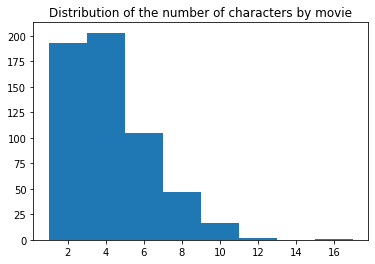

In [39]:
X = np.ones(cornell_prepro_characters.shape[0])
y = np.ones(cornell_prepro_characters.shape[0])
groups = cornell_prepro_characters['movieID']
samples_in_test = []
for train, test in LeaveOneGroupOut().split(X,y,groups):
    samples_in_test.append(len(test))
samples_in_test

d = np.diff(np.unique(samples_in_test)).min()
left_of_first_bin = np.min(samples_in_test) - float(d)/2
right_of_last_bin = np.max(samples_in_test) + float(d)/2
plt.hist(samples_in_test, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.title('Distribution of the number of characters by movie')
plt.show()